In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize']= 10,6
from matplotlib.ticker import StrMethodFormatter
color = sns.color_palette()

In [2]:
pwd!

'/Users/shaivya/Downloads'

In [3]:
data_file=pd.read_csv('take-home_exercise_data.csv')

In [4]:
data_file.head(5)

,Unnamed: 0,prospectid,ordernumber,ordercreatedate,regtenure,customer_type_group,dnatestactivationdayid,daystogetresult_grp,dna_visittrafficsubtype,xsell_gsa,xsell_day_exact
0,1,93771712,127707306,2014-11-28,More than 120 days old,Existing Reg,2014-12-10,4 weeks,NaN,1,38.0
1,2,123112555,114401425,2013-12-05,Order prior to reg,New Reg,2014-01-13,4 weeks,NaN,1,40.0
2,3,171965960,159656050,2016-11-25,Order prior to reg,New Reg,NaN,-1,Paid Search Non Brand,0,NaN
3,4,175522116,165370285,2017-03-08,<=60 days,Existing Reg,NaN,-1,Email Programs,0,NaN
4,5,149288086,132837125,2015-03-30,Order prior to reg,New Reg,2015-04-06,4 weeks,NaN,0,NaN


# Description --
        
        prospectid : unique (customer wise)
        ordernumber : unique (DNA product wise)
        ordercreatedate : DNA product ordered date
        regtenure : email id registered days
        customer_type_group : type of customer of DNA product
        dnatestactivationdayid : DNA test activated date
        daystogetresult_grp : days taken to get results of DNA test
        dna_visittrafficsubtype : DNA product traffic medium/channel
        xsell_gsa : indicates ACOM subscriber
        xsell_day_exact : days b/w DNA product sale & ACOM subscription 
        

In [6]:
### Dropping the first column 
data_file=data_file.drop(data_file.columns[0], axis=1)

In [7]:
### Datatype of each column wrt their description
data_file.dtypes

prospectid                   int64
ordernumber                  int64
ordercreatedate             object
regtenure                   object
customer_type_group         object
dnatestactivationdayid      object
daystogetresult_grp         object
dna_visittrafficsubtype     object
xsell_gsa                    int64
xsell_day_exact            float64
dtype: object

In [8]:
### Total number of customers
data_file['prospectid'].count()

251942

MAKING LABELS -- 
As per problem statement the label for cross sell has to be definef under two conditions
                    
    1) xsell_gsa == 1 (The customer became a ACOM subscriber)
    2) xsell_day_exact <= 120 (The customer purchased their ACOM within 120 days of their DNA product)

In [10]:
data_file['xsell_derived'] = np.where(data_file['xsell_day_exact']<=120, 'Within 120 days', 'More than 120 days')

In [11]:
data_file["Cross_sell_customer"]=np.where((data_file["xsell_gsa"] == 1) & (data_file["xsell_derived"] == "Within 120 days"),1,0)

In [12]:
data_file['ordercreatedate'] = pd.to_datetime(data_file['ordercreatedate'])
data_file['dnatestactivationdayid'] = pd.to_datetime(data_file['dnatestactivationdayid'])

In [13]:
data_file['date_diff'] = (data_file['dnatestactivationdayid'] - data_file['ordercreatedate']).dt.days

# Cleaning 

In [14]:
##  check any missing or NA or NAN values in columns of data set
data_file.columns[data_file.isnull().any()].tolist()

['dnatestactivationdayid',
 'dna_visittrafficsubtype',
 'xsell_day_exact',
 'date_diff']

In [15]:
## Some charcater value in "dna_visittrafficsubtype" variable
data_file["dna_visittrafficsubtype"] = data_file["dna_visittrafficsubtype"].str.replace(" ‰ÛÒ", "")

In [16]:
## -1 values in daystogetresult_grp and comparing it with variable dnatestactivationdayid
data_file_clean=data_file[(data_file["dnatestactivationdayid"].isna()==False) |
                          (data_file["daystogetresult_grp"] != "-1")]

In [146]:
data_file_clean["prospectid"].count()

178845

# Imputation

In [18]:
from math import ceil
import re

def impute_daystogetresult_grp(date_diff):
    weeks = ceil(date_diff/7)
    return "{} week".format(weeks)

def impute_daystogetresult_grp_regx(value):
    output = re.findall(r'\d+',value)
    return "{} week".format(output[0])


In [19]:
data_file_clean['daystogetresult_grp'] = np.where(data_file_clean.daystogetresult_grp=='-1', 
                                                  np.where(data_file_clean.Cross_sell_customer==1,
                                                           data_file_clean[data_file_clean.Cross_sell_customer==1]['daystogetresult_grp'].mode(),
                                                           data_file_clean[data_file_clean.Cross_sell_customer==0]['daystogetresult_grp'].mode()),
                                                  data_file_clean['daystogetresult_grp']
                                                 )

/Users/shaivya/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [20]:
data_file_clean.head()

,prospectid,ordernumber,ordercreatedate,regtenure,customer_type_group,dnatestactivationdayid,daystogetresult_grp,dna_visittrafficsubtype,xsell_gsa,xsell_day_exact,xsell_derived,Cross_sell_customer,date_diff
0,93771712,127707306,2014-11-28,More than 120 days old,Existing Reg,2014-12-10,4 weeks,NaN,1,38.0,Within 120 days,1,12.0
1,123112555,114401425,2013-12-05,Order prior to reg,New Reg,2014-01-13,4 weeks,NaN,1,40.0,Within 120 days,1,39.0
4,149288086,132837125,2015-03-30,Order prior to reg,New Reg,2015-04-06,4 weeks,NaN,0,NaN,More than 120 days,0,7.0
5,58994698,101317667,2012-10-26,More than 120 days old,Acom Sub,2012-11-30,4 weeks,NaN,0,NaN,More than 120 days,0,35.0
6,172404474,166005278,2017-03-19,<=120 days,Existing Reg,2017-03-26,4 weeks,Email Programs,0,NaN,More than 120 days,0,7.0


In [ ]:
######## Checking in both the groups (cross selled customers and non cross selled customers for varitions)

In [23]:
data_file_clean_cross_selled=data_file_clean[data_file_clean["Cross_sell_customer"]==1]

In [24]:
data_file_clean_non_cross_selled=data_file_clean[data_file_clean["Cross_sell_customer"]==0]

In [25]:
data_file_clean_cross_selled["date_diff"].describe()

count    27330.000000
mean        22.240176
std         50.617561
min          1.000000
25%          7.000000
50%         10.000000
75%         19.000000
max       1437.000000
Name: date_diff, dtype: float64

In [26]:
data_file_clean_non_cross_selled["date_diff"].describe()

count    151515.000000
mean         32.191532
std         332.896316
min           1.000000
25%           7.000000
50%          11.000000
75%          23.000000
max       42462.000000
Name: date_diff, dtype: float64

In [27]:
data_file_clean_cross_selled.date_diff.quantile(0.98)   

130.0

In [28]:
data_file_clean_non_cross_selled.date_diff.quantile(0.98)

224.0

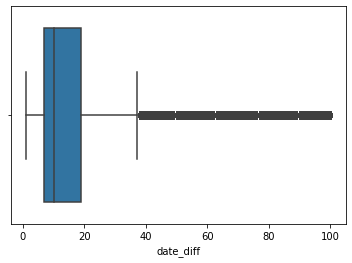

In [31]:
sns.boxplot(data_file_clean_imp[data_file_clean_imp.date_diff<=100]['date_diff'].dropna())

In [33]:
### Filling NaN values by source unknown 
data_file_clean_imp["dna_visittrafficsubtype"] = data_file_clean_imp.dna_visittrafficsubtype.fillna('source_unknown')

/Users/shaivya/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


# Multiple orders

In [34]:
gb_prospectid = data_file_clean_imp[['prospectid','ordernumber']].groupby('prospectid').count()

In [35]:
gb_prospectid[gb_prospectid.ordernumber>1].count()

ordernumber    18990
dtype: int64

In [36]:
gb_prospectid.rename(columns={'ordernumber':'order_count'},inplace=True)

In [37]:
gb_prospectid.reset_index(level=0,inplace=True)

In [38]:
data_file_clean_imp = data_file_clean_imp.merge(gb_prospectid,how='left',on='prospectid')

In [144]:
data_file_clean_imp["prospectid"].count()

174982

In [164]:
### how do the 'order_count','xsell_day_exact look like

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a1d94bb00>,
      dtype=object)

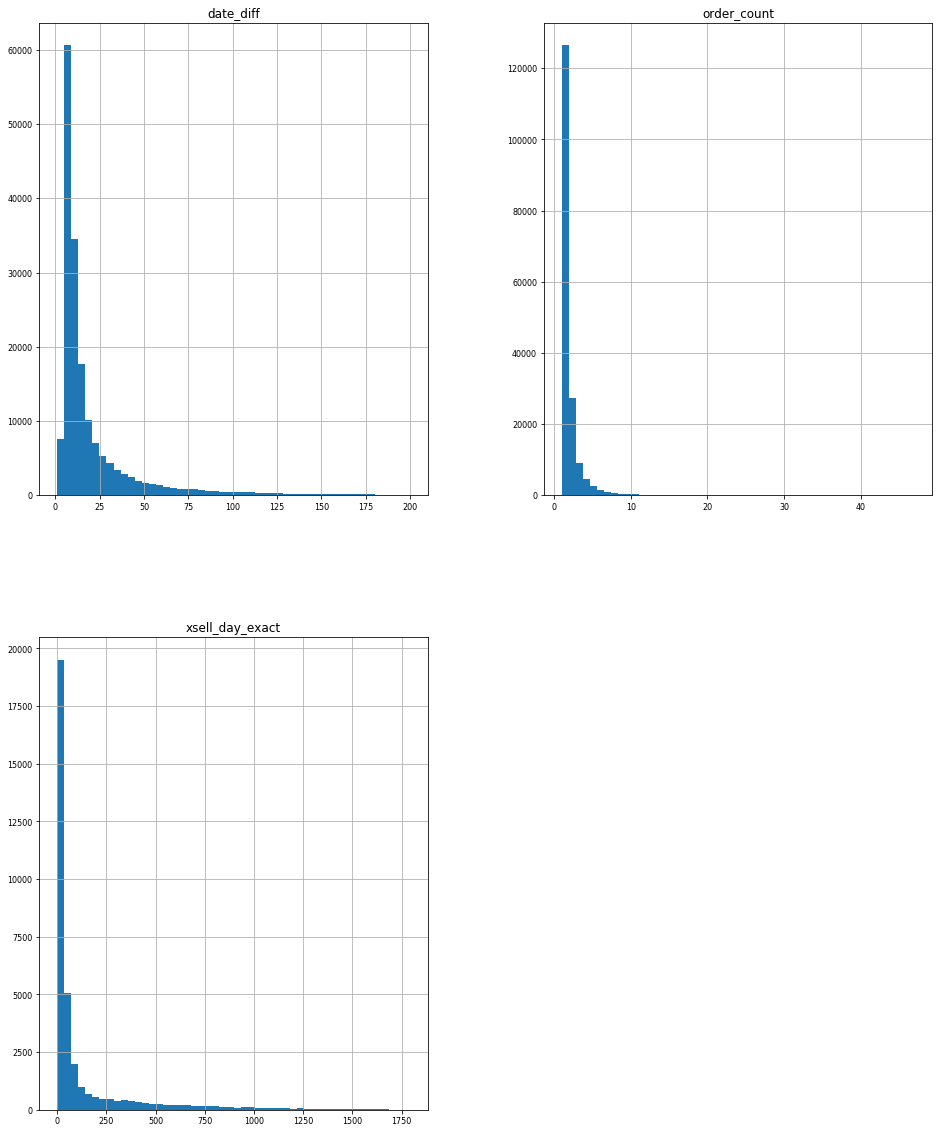

In [46]:
data_file_clean_imp[['date_diff','order_count','xsell_day_exact']].hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8)

# Corelation

In [150]:
#### Numeric variables
num_corr=pd.DataFrame(data_file_clean_imp.corr(method="pearson")['Cross_sell_customer'])

In [151]:
num_corr

,Cross_sell_customer
prospectid,0.074985
ordernumber,0.043108
xsell_gsa,0.855209
xsell_day_exact,-0.770291
Cross_sell_customer,1.000000
date_diff,-0.039897
order_count,-0.099146


In [152]:
### For categorical variables

import scipy.stats as ss
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

In [160]:
cramers_v(data_file_clean_imp['customer_type_group'],data_file_clean_imp['Cross_sell_customer'])

0.2522011449479725

In [161]:
cramers_v(data_file_clean_imp['dna_visittrafficsubtype'],data_file_clean_imp['Cross_sell_customer'])

0.10309938625365392

In [162]:
cramers_v(data_file_clean_imp['regtenure'],data_file_clean_imp['Cross_sell_customer'])

0.08961696429344314

# Visualising thrg Graphs

In [ ]:
### graphing the first categorical impt variable
data_file_clean_imp['regtenure'].value_counts().plot.bar()
plt.xlabel('Number of customer registered email id', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Countplot - customer registered email id ',fontsize=13)
plt.show()
plt.savefig("countplot_email.png")

In [ ]:
### graphing the second categorical impt variable
data_file_clean_imp['customer_type_group'].value_counts().plot.bar()
plt.xlabel('Type of customer', fontsize=12)
plt.ylabel('Count_by_customer_type', fontsize=12)
plt.title('Countplot -  customer type',fontsize=13)
plt.show()
plt.savefig("countplot_cust_typ.png")

customer_type_group  Acom Sub  Existing Reg  New Reg
xsell_gsa                                           
0                       57059         44180    38793
1                        6211         17422    11317


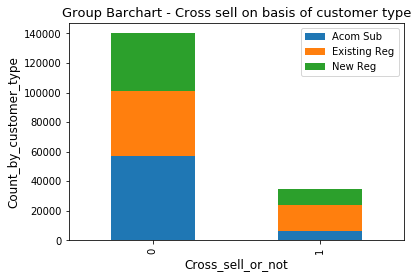

In [115]:
### Customer type vs cross sell
customer_type_vs_cross_sell = pd.crosstab(index=data_file_clean_imp["xsell_gsa"], 
                          columns=data_file_clean_imp["customer_type_group"])
print(customer_type_vs_cross_sell)
customer_type_vs_cross_sell.plot.bar(stacked=True)
plt.xlabel('Cross_sell_or_not', fontsize=12)
plt.ylabel('Count_by_customer_type', fontsize=12)
plt.title('Group Barchart - Cross sell on basis of customer type',fontsize=13)
plt.show()

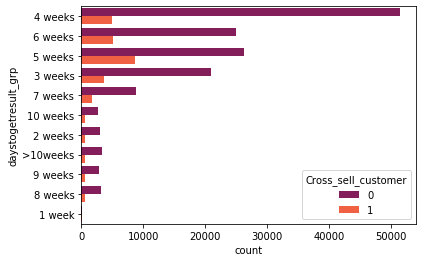

In [141]:
### daystogetresult vs cross sell 
gh=sns.countplot(y="daystogetresult_grp",hue="Cross_sell_customer",data=data_file_clean_imp,
              palette="rocket",saturation=4)

In [ ]:
### count plot of regtenure vs cross sell
sns.countplot(y="regtenure",hue="Cross_sell_customer",data=data_file_clean_imp,
              saturation=4).set_title("Cross sell on basis of number of customers regsitering email id")

Text(0.5, 0.98, 'Cross analysis - Customer type wise count plot of customer registered their email id ')

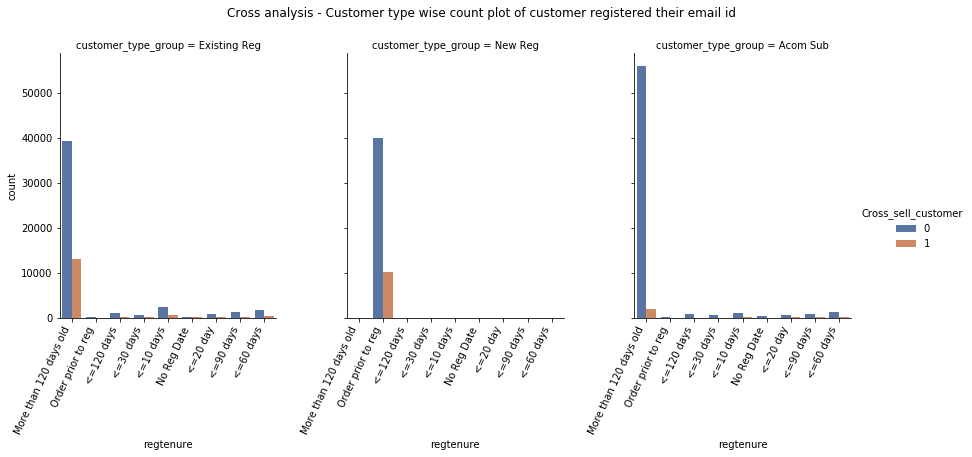

In [163]:
### regtenure(emailid reg) vs cross sell vs customer type 

chart=sns.catplot(x="regtenure",hue="Cross_sell_customer",col="customer_type_group",aspect=0.8,palette="deep"
            ,data=data_file_clean_imp,kind='count')

for axes in chart.axes.flat:
    axes.set_xticklabels(axes.get_xticklabels(), rotation=65, horizontalalignment='right')

plt.subplots_adjust(top=0.85)
chart.fig.suptitle('Cross analysis - Customer type wise count plot of customer registered their email id ')

Text(0.5, 0.98, 'Cross analysis - Days to get result of DNA product')

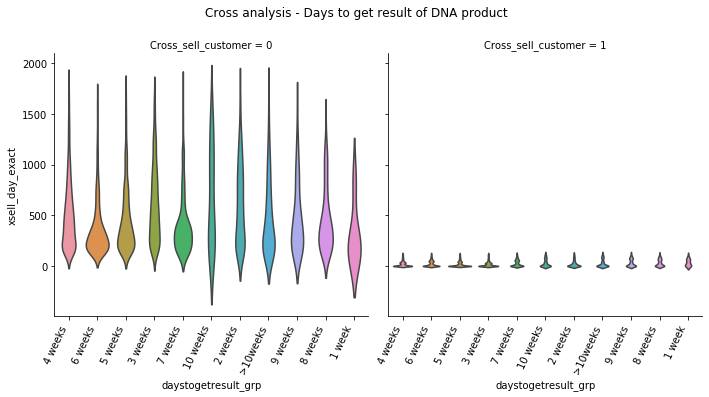

In [143]:
g=sns.catplot(x="daystogetresult_grp",y="xsell_day_exact", col="Cross_sell_customer",
            kind="violin" ,inner=None,data=data_file_clean_imp)

for axes in g.axes.flat:
    axes.set_xticklabels(axes.get_xticklabels(), rotation=65, horizontalalignment='right')
    
plt.subplots_adjust(top=0.85)
g.fig.suptitle('Cross analysis - Days to get result of DNA product')

# traffic distribution

In [52]:
data_file_traffic = data_file_clean_imp.groupby('dna_visittrafficsubtype')['ordernumber'].agg({'ordernumber':'count'})

sum_traffic = data_file_traffic['ordernumber'].sum()

data_file_traffic['percentage'] = (data_file_traffic['ordernumber']/sum_traffic)*100

data_file_traffic.head()

data_file_traffic_dict = data_file_traffic[['percentage']].to_dict()

data_file_traffic_dict = data_file_traffic_dict['percentage']

/Users/shaivya/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version. Use                 named aggregation instead.

    >>> grouper.agg(name_1=func_1, name_2=func_2)

  """Entry point for launching an IPython kernel.


In [53]:
data_file_clean_imp['dna_visittrafficsubtype_new'] = data_file_clean_imp['dna_visittrafficsubtype'].apply(
    lambda x: 'Misc' if data_file_traffic_dict.get(x,0)<=2 else x)

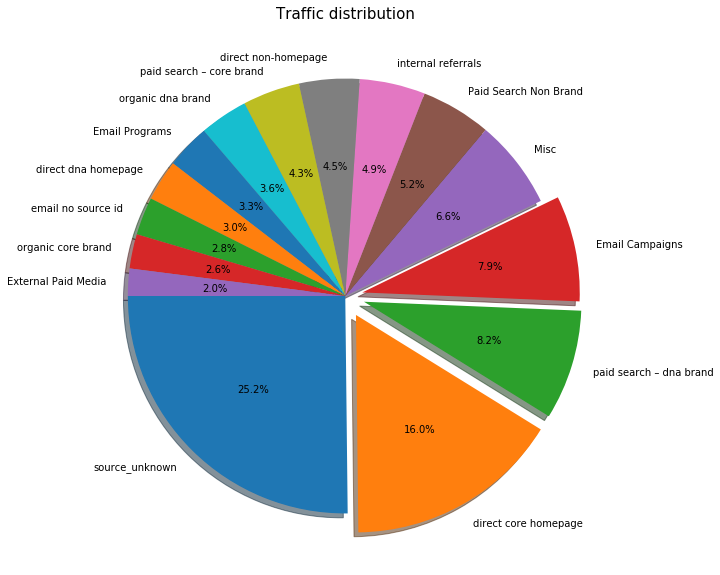

<Figure size 432x288 with 0 Axes>

In [62]:
### Traffic distribution in pie chart
plt.figure(figsize=(10,10))

temp_series = data_file_clean_imp['dna_visittrafficsubtype_new'].value_counts()
labels = (np.array(temp_series.index))
sizes = (np.array((temp_series / temp_series.sum())*100))
explode=(0,0.1,0.09,0.08,0,0,0,0,0,0,0,0,0,0,0)
plt.pie(sizes, labels=labels,explode=explode, shadow=True,
        autopct='%1.1f%%', startangle=180)
plt.title("Traffic distribution", fontsize=15)
plt.show()
plt.savefig("traffic_distribution.png")

In [63]:
### looking at Misc source of traffic separately
data_file_clean_imp_misc_td=data_file_clean_imp[data_file_clean_imp['dna_visittrafficsubtype_new']=="Misc"]

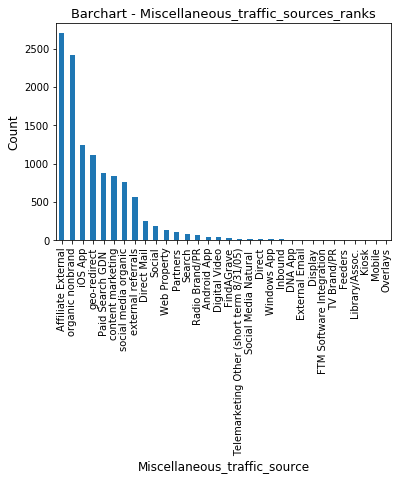

In [130]:
data_file_clean_imp_misc_td["dna_visittrafficsubtype"].value_counts().plot.bar()
plt.xlabel('Miscellaneous_traffic_source', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Barchart - Miscellaneous_traffic_sources_ranks',fontsize=13)
plt.show()